In [1]:
from time import time
import json
import pickle
import copy
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from itertools import islice
from qiskit import transpile, ClassicalRegister
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix, Operator
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch, Sampler, Options
#from qiskit.providers.ibmq.managed import IBMQJobManager
from utilities import IBM_startup, bit_str_list, run_cal, load_cal
from teleportation import Teleportation, calc_negativities, calc_n_mean, calc_teleported_negativities, plot_teleported_negativities_multi_gap, teleported_negativities_multi_gap_data


In [ ]:
def fit(x, m, c):
     return m*x + c
def log_fit(x, a, b):
     return a*np.log(x)+b

def logit_fit(x, a, b, c):
     return a/(1+np.exp((b*x+c)))

Quantinuum results plots

In [59]:
nmit_opt = np.array([0.920444946, 0.889881027, 0.886573283, 0.832597644, 0.818487764, 0.809847014, 0.803271522, 0.734017791, 0.761163855, 0.730839454, 
                     0.694339227, 0.653438522, 0.620225724, 0.579619621, 0.607329651, 0.635502698, 0.621721773, 0.544990469, 0.503803368])
n_opt = np.array([0.947609776, 0.926847946, 0.917523769, 0.902381927, 0.886724383, 0.859678984, 0.856992541, 0.833725823, 0.802073652, 0.757925506, 
                  0.736152721, 0.718828269, 0.683210109, 0.689142068, 0.666293937, 0.659916777, 0.64657301, 0.599543498, 0.606430211])
err_opt = np.array([0.942047903, 0.914440188, 0.8901626, 0.906329294, 0.896909418, 0.876498966, 0.833732915, 0.779900736, 0.745998798, 0.616806731, 
                    0.669498765, 0.654143831, 0.612919651, 0.618939184, 0.622560077, 0.608898143, 0.545571051, 0.479474639, 0.37721859])

print(list(np.minimum(err_opt, np.minimum(nmit_opt, n_opt))))
print(list((nmit_opt+n_opt+err_opt)/3))

[0.920444946, 0.889881027, 0.886573283, 0.832597644, 0.818487764, 0.809847014, 0.803271522, 0.734017791, 0.745998798, 0.616806731, 0.669498765, 0.653438522, 0.612919651, 0.579619621, 0.607329651, 0.608898143, 0.545571051, 0.479474639, 0.37721859]
[0.936700875, 0.9103897203333333, 0.8980865506666666, 0.8804362883333333, 0.867373855, 0.848674988, 0.8313323260000001, 0.7825481166666667, 0.7697454349999999, 0.7018572303333334, 0.6999969043333333, 0.6754702073333333, 0.6387851613333333, 0.6292336243333333, 0.6320612216666667, 0.6347725393333333, 0.6046219446666666, 0.541336202, 0.49581738966666666]


In [3]:
#Negativity
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
ibm_dyn_max = [0.3876333, 0.31945503, 0.28867057, 0.25294873, 0.17145066, 0.14545065,
               0.19946986, 0.20518745, 0.20086907, 0.13836296, 0.10110426, 0.08100343,
               0.04250083, 0.02884917, 0.02465277, 0.00714491, 0.01631592, 0.0059555, 0]
ibm_dyn_min = [0.304345194, 0.245245739, 0.269170392, 0.157261605, 0.149879745, 0.068658572, 0.129795988, 0.056035899, 0.131184833, 0.087229385, 0.097410333, 0.041432681, 0.016179014, 0.011256005, 0.005530828, 0.0, 0.0, 0.0, 0.0]
ibm_dyn_mean = [0.3383111976666667, 0.28092134966666665, 0.2766962783333333, 0.20449848933333334, 0.162051694, 0.11716858433333333, 0.15418647333333335, 0.12987784633333335, 0.15957199766666666, 0.118334082, 0.09981672333333334, 0.06541014033333334, 0.03095614166666667, 0.021504231, 0.012518285999999998, 0.0024176196666666665, 0.006255215666666667, 0.002413192, 0.0]

ibm_post_max = [0.45034312, 0.43061408, 0.42060718, 0.40876229, 0.40036279, 0.38067163,
                0.3598705,  0.33753487, 0.30615023, 0.26324849, 0.23979248, 0.22240192,
                0.18510016, 0.19175616, 0.17092309, 0.16356217, 0.15169792, 0.10102412, 0.10773931]
ibm_post_min = [0.422641626, 0.395310389, 0.391432224, 0.339161179, 0.321813438, 0.31292425, 0.306046358, 0.239558571, 0.250820096, 0.13157012, 0.171804502, 0.156083081, 0.116719585, 0.085647389, 0.111497463, 0.111064309, 0.075728166, 0.04437799, 0.0]
ibm_post_mean = [0.439324797, 0.41450214766666665, 0.40165017799999997, 0.38431093699999996, 0.37085154400000003, 0.352375387, 0.33496703899999997, 0.28728963199999996, 0.273390846, 0.20927378066666666, 0.20362813533333332, 0.17853622666666666, 0.14325517166666668, 0.13292289866666665, 0.1357430616666667, 0.13752291400000002, 0.11713366666666665, 0.069145629, 0.04724751733333333]

gaps_long = [i for i in range(1,76)]
quantinuum_simulated_dyn_mit = [0.479213267, 0.477876158, 0.474463777, 0.466464058, 0.468910919, 0.463704282, 0.463720283, 0.455802306, 
                                0.457315924, 0.449594285, 0.444299805, 0.439524804, 0.437753951, 0.432709682, 0.432508178, 0.426312403, 
                                0.422828176, 0.419237636, 0.413743786,0.413648797,0.405628281,0.408879186,0.396473354,0.39833422,0.39083383,0.389367947,0.397035753,0.381818437,0.381578947,0.372600028,0.375569752,0.371085773,0.370973608,0.359298668,0.352474077,0.351776617,0.350748161,0.353334577,0.350145315,0.346225298,0.343040207,0.336464237,0.327627263,0.334552311,0.323234462,0.331839565,0.324070767,0.313985459,0.31603634,0.321322869,0.298524091,0.315273339,0.303696248,0.305696231,0.304535314,0.289364458,0.302027576,0.289522181,0.288409849,0.282825122,0.275162243,0.281769143,0.26993566,0.272961117,0.268564131,0.272188848,0.259240542,0.254694196,0.254705651,0.264777607,0.2436586,0.246874867,0.244227782,0.248021908,0.245023351]

quantinuum_simulated_dyn_mit_err = [0.001844394, 0.001338654, 0.00055704, 0.003628583, 0.002261824, 0.001953944, 0.001357591, 
                                    0.001268042, 0.002053766, 0.003374918, 0.00251668, 0.002400165, 0.001534435, 0.001400271, 
                                    0.003874444, 0.001990538, 0.001747095, 0.002949284, 0.003056895,0.003704784,0.004990433,0.002593563,0.006951691,0.00222331,0.002485504,0.003529415,0.002501704,0.003685349,0.00431005,0.005797942,0.004241076,0.00361702,0.003565684,0.002165598,0.005128499,0.004676221,0.006885063,0.002983259,0.002995919,0.00467724,0.00470726,0.006526698,0.006926787,0.001823779,0.001796706,0.002298042,0.003541026,0.00564736,0.004390292,0.00321388,0.002942988,0.006440873,0.003307372,0.003043676,0.003905493,0.00508263,0.00558644,0.003884416,0.00410376,0.003394735,0.007897554,0.006182688,0.003862619,0.001044344,0.007369325,0.003945712,0.004868904,0.004500742,0.004107466,0.006510132,0.003104943,0.007479931,0.004750804,0.002165917,0.000975936]

quantinuum_simulated_post_mit = [0.476922248, 0.468522375, 0.464641159, 0.462606715, 0.458283003, 0.457766825, 0.452881307, 
                                 0.450893486, 0.443183439, 0.441237983, 0.43750251, 0.438036308, 0.433415281, 0.429196291, 0.42783847, 
                                 0.423018722, 0.417720494, 0.410855879, 0.408781675,0.403338392,0.399084498,0.402961785,0.396662683,0.390544987,0.393857468,0.386623501,0.389174449,0.389053148,0.379436481,0.372590374,0.378782492,0.374921459,0.366904063,0.359355893,0.361420501,0.355831981,0.352234326,0.348617829,0.347444719,0.345404379,0.342949532,0.342039781,0.32825148,0.329846427,0.326853474,0.331810093,0.317987488,0.325611208,0.319791372,0.307965144,0.305609949,0.315077959,0.300531722,0.30294394,0.299125002,0.295901374,0.286632906,0.291747543,0.290295158,0.278049186,0.288948557,0.280663426,0.280508112,0.273061376,0.270228184,0.262885794,0.264124718,0.264813252,0.258026249,0.257408236,0.258003573,0.243381126,0.247045218,0.250167062,0.245561762]
quantinuum_simulated_post_mit_err = [0.003129049, 0.00269278, 0.001008007, 0.00158551, 0.002302754, 0.00151759, 0.002008983, 0.001492215, 
                                     0.000947087, 0.000956193, 0.003099501, 0.002027381, 0.001249532, 0.001609658, 0.002001632, 0.003279223, 
                                     0.002338918, 0.002137588, 0.003011398,0.003681579,0.003292271,0.00371726,0.00430583,0.003553666,0.002975766,0.002581833,0.003837788,0.002510007,0.003248576,0.003532349,0.003916672,0.003651889,0.00451587,0.003976184,0.003140623,0.003223932,0.003330031,0.004526669,0.003597934,0.004759158,0.004819522,0.003826072,0.004583982,0.005132661,0.005424256,0.004002457,0.003479339,0.00326043,0.004640631,0.00381327,0.004725713,0.002921173,0.004136517,0.003896173,0.004893378,0.005095401,0.004546257,0.005655192,0.005198602,0.004052479,0.004161653,0.004202289,0.005071857,0.005824762,0.006899363,0.005268114,0.006592951,0.005784605,0.004911718,0.00470819,0.004597316,0.005911798,0.004169088,0.005897011,0.005719759]

quantinuum_ideal_mit = [0.5]*75
quantinuum_real_dyn_mit = [0.452241344, 0.38205548, 0.287710572]
quantinuum_real_dyn_mit_err = [0.02147, 0.02147, 0.02147] #\epsilon = \sqrt{(0.5-0)^2*ln(2/delta)/(2*shots)} (delta = 1-0.95)

In [7]:
#Fidelity

ibm_dyn_max = [0.86017609, 0.80039978, 0.78438187, 0.74837875, 0.66458893, 0.63854599, 
               0.69865418, 0.70345306, 0.6985817, 0.6360817, 0.59969711, 0.56547546,
               0.51202011, 0.4941597, 0.45946503, 0.43927765, 0.44576263, 0.44417572, 0.42533875]
ibm_dyn_min = [0.779457092, 0.714286804, 0.765964508, 0.623332977, 0.644821167, 0.552677155, 0.62538147, 0.52432251, 0.629951477, 0.575008392, 0.592319489, 0.484695435, 0.46087265, 0.427467346, 0.410636902, 0.393791199, 0.39736557, 0.397697449, 0.377738953]
ibm_dyn_mean = [0.8104426063333333, 0.7578773496666668, 0.7721710203333334, 0.6885503133333333, 0.652656555, 0.6044006350000001, 0.6503181459999999, 0.6181004843333333, 0.6568743389999999, 0.6122500103333334, 0.595513662, 0.5368423463333333, 0.488834381, 0.4548072813333333, 0.4421424866666667, 0.4221293133333333, 0.42234039300000004, 0.4252611796666667, 0.3964716593333333]

ibm_post_max = [0.94760978, 0.92684795, 0.91752377, 0.90632929, 0.89690942, 0.87649897,
                0.85699254, 0.83372582, 0.80207365, 0.75792551, 0.73615272, 0.71882827,
                0.68321011, 0.68914207, 0.66629394, 0.65991678, 0.64657301, 0.5995435, 0.60643021]
ibm_post_min = [0.920444946, 0.889881027, 0.886573283, 0.832597644, 0.818487764, 0.809847014, 0.803271522, 0.734017791, 0.745998798, 0.616806731, 0.669498765, 0.653438522, 0.612919651, 0.579619621, 0.607329651, 0.608898143, 0.545571051, 0.479474639, 0.37721859]
ibm_post_mean = [0.936700875, 0.9103897203333333, 0.8980865506666666, 0.8804362883333333, 0.867373855, 0.848674988, 0.8313323260000001, 0.7825481166666667, 0.7697454349999999, 0.7018572303333334, 0.6999969043333333, 0.6754702073333333, 0.6387851613333333, 0.6292336243333333, 0.6320612216666667, 0.6347725393333333, 0.6046219446666666, 0.541336202, 0.49581738966666666]

quantinuum_simulated_dyn_mit = [0.978876577, 0.977191397, 0.97384154, 0.965782509, 0.967848032, 0.963247689, 0.962983701, 
                                0.955060997, 0.95663469, 0.948981879, 0.943823785, 0.938978892, 0.93720296, 0.93216643, 
                                0.932007897, 0.925473277, 0.922192091, 0.918557727, 0.912757549,0.912056424,0.90455996,0.907681114,0.8955,0.897450915,0.8895,0.887875,0.896125,0.880625,0.880875,0.871149625,0.8735,0.869363639,0.87,0.857598649,0.850625,0.850375,0.848375,0.85075,0.84725,0.8445,0.84,0.834125,0.826,0.831365078,0.820375,0.83025,0.821875,0.812,0.812125,0.8185,0.79525,0.812375,0.80125,0.8015,0.8015,0.78625,0.798625,0.785279382,0.78425,0.778375,0.7725,0.7775,0.766375,0.769,0.764875,0.768375,0.7545,0.7515,0.751125,0.762,0.73825,0.741,0.739625,0.742,0.739125]

quantinuum_simulated_dyn_mit_err = [0.001867421, 0.001186439, 0.00065358, 0.003597935, 0.00210469, 0.002063881, 0.001383553, 0.001383557, 
                                    0.001810425, 0.003396559, 0.002560386, 0.002452687, 0.001548708, 0.001380904, 0.003841058, 0.001829019, 
                                    0.001507442, 0.00309106, 0.002853634,0.003652831,0.004858521,0.002328932,0.007153088,0.002484609,0.002300362,0.003337757,0.002478028,0.003732599,0.004130047,0.006259916,0.00448609,0.003486463,0.00340343,0.002014989,0.00472306,0.004379759,0.006693825,0.002890358,0.002975595,0.00487767,0.004839077,0.006135196,0.006822145,0.002208619,0.002248842,0.002367312,0.002831188,0.005802298,0.004638494,0.003576544,0.002569857,0.006371731,0.003294566,0.002637865,0.003835144,0.004225419,0.005792866,0.004144393,0.00383786,0.003826307,0.00748053,0.006214901,0.002967708,0.001457738,0.007338185,0.004709808,0.004406435,0.004677072,0.003151554,0.006093029,0.002897556,0.007097535,0.004930243,0.00276134,0.001712394]

quantinuum_simulated_post_mit = [0.97622987, 0.966973676, 0.962960849, 0.961263733, 0.956690304, 0.955873504, 0.951013312, 0.949478543, 
                                 0.941183778, 0.939368147, 0.936023125, 0.935701506, 0.931914362, 0.927377066, 0.92556901, 0.920117103, 
                                 0.915252945, 0.909207821, 0.905786822,0.90071766,0.896474602,0.900333053,0.89455529,0.888016888,0.891056417,0.883418075,0.886843642,0.886095853,0.876750138,0.869526022,0.875875433,0.871797565,0.864034844,0.856443692,0.858769939,0.852914164,0.848753361,0.844807568,0.842358161,0.84215317,0.837810697,0.837684927,0.82480837,0.825292962,0.821626784,0.827841769,0.814517857,0.820904914,0.81669482,0.803818515,0.801338188,0.811766195,0.796999141,0.799341314,0.794703677,0.788153188,0.780708261,0.787797853,0.784266654,0.772402956,0.783156095,0.775282022,0.774920795,0.766842335,0.764389003,0.756944754,0.756425363,0.759490911,0.750721496,0.751394855,0.751578691,0.738024156,0.740599815,0.740665832,0.734625074]
quantinuum_simulated_post_mit_err = [0.00311968, 0.002666922, 0.001006872, 0.00161158, 0.002049209, 0.001525763, 0.001965584, 0.001308031, 
                                     0.000865504, 0.000895219, 0.003310637, 0.00180891, 0.001123208, 0.00152408, 0.002099192, 0.003401363, 
                                     0.002459846, 0.002139177, 0.00293071,0.003696379,0.003265917,0.003751997,0.004367674,0.003461445,0.002943037,0.002690195,0.003794828,0.002567786,0.003276591,0.003324367,0.003984089,0.003802751,0.004494938,0.004046675,0.003159778,0.003245927,0.003187392,0.004469389,0.003908489,0.004616558,0.005032763,0.003703435,0.00473349,0.005135972,0.005320342,0.004198591,0.003335661,0.003051651,0.004581461,0.004077014,0.004465836,0.002855685,0.003988243,0.00382438,0.004993591,0.004863571,0.004836242,0.005833859,0.004964516,0.003720511,0.004326448,0.004025424,0.004648582,0.006162403,0.006830864,0.004684207,0.006527597,0.006164477,0.00491863,0.004932303,0.004477666,0.005794563,0.003741073,0.005617175,0.005812006,]

quantinuum_ideal_mit = [1]*75
quantinuum_real_dyn_mit = [0.951143864, 0.881423465, 0.787]
quantinuum_real_dyn_mit_err = [0.04295]*3 #\epsilon = \sqrt{(0.5-0)^2*ln(2/delta)/(2*shots)} (delta = 1-0.95)


In [12]:
#Negativity (QREM)
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
ibm_dyn_max = [0.42473453, 0.36305338, 0.32678037, 0.30532103, 0.26267503, 0.17934714, 0.2107311, 0.22015515,
               0.20946477, 0.14367225, 0.10455412, 0.08198304, 0.04720851, 0.02910351, 0.01634467, 0.0013677,
               0.00322212, 0.00127798, 0.00325832]

ibm_dyn_min = [0.33699399, 0.26548759, 0.29073986, 0.1641823, 0.17350246, 0.08048024,
               0.14026632, 0.06842255, 0.15938973, 0.09343604, 0.08784035, 0.04215754,
               0.01714063, 0.01139297, 0.00570229, 0, 0, 0, 0]

ibm_dyn_mean = [0.37580264, 0.31057952, 0.3110956, 0.24825878, 0.21232015, 0.13992481,
                0.17187055, 0.14467581, 0.18044148, 0.11591184, 0.09751756, 0.06502055,
                0.0330188, 0.01930833, 0.00981504, 0.00048793, 0.00189129, 0.00042599, 0.00108611]

ibm_post_max = [0.47906859, 0.45718078, 0.45634955, 0.44157687, 0.44042812, 0.42281491, 0.41814373, 0.39085776,
                0.40647608, 0.36440982, 0.29668423, 0.23617984, 0.19276192, 0.19604149, 0.17342829, 0.16507905,
                0.15257961, 0.10188943, 0.10792068]

ibm_post_min = [0.47135797, 0.4466907, 0.4351057, 0.40318152, 0.43229463, 0.40360568,
                0.39925493, 0.34643464, 0.31559443, 0.21624412, 0.21966299, 0.18288691,
                0.13143536, 0.09789076, 0.11719691, 0.11314383, 0.07646058, 0.04480683,
                0]

ibm_post_mean = [0.47427978, 0.45078969, 0.44886615, 0.42739971, 0.43706776, 0.41331452,
                 0.41162071, 0.3642579, 0.35971244, 0.29222523, 0.25925444, 0.20749982,
                 0.15879143, 0.14099531, 0.13997063, 0.14009538, 0.1180661, 0.06976478, 0.04737487]


quantinuum_simulated_dyn_mit = [0.484286519, 0.483987383, 0.480439959, 0.474067625, 0.475822738, 0.471189937, 
                                0.470083509, 0.462597788, 0.463648976, 0.456698514, 0.452240484, 0.446874378, 
                                0.444383503, 0.44050008, 0.439056804, 0.433726285, 0.429110755, 0.42533529, 
                                0.420268482,0.42077723,0.411346626,0.41462867,0.402316708,0.404304884,0.397928757,
                                0.396445449,0.404228148,0.391172146,0.387932677,0.378603864,0.388235726,0.378051033,
                                0.377277016,0.36673836,0.358907284,0.358779085,0.356397325,0.360479381,0.356747993,
                                0.351759692,0.349417601,0.343868503,0.332283011,0.339917744,0.329856462,0.338766573,
                                0.329609566,0.318543185,0.321302779,0.326988098,0.303274375,0.320355877,0.309985008,
                                0.311558194,0.310968848,0.294374301,0.308515552,0.295171076,0.29348609,0.288442897,
                                0.281782415,0.286039138,0.274826717,0.279023172,0.274739788,0.277208506,0.263317999,
                                0.259391448,0.259656575,0.269225607,0.24817439,0.252492093,0.249565866,0.252609288,
                                0.251124893, 0.278487409,0.284279729,0.274804494,0.267452482,0.276162836,0.263739373,
                                0.261149975,0.266172153,0.257063763,0.254754779,0.254584937,0.245757249,0.242872875,
                                0.253983538,0.246450514,0.242077278,0.246574734,0.240724314,0.244707202,0.237792783,
                                0.233446613,0.225798722,0.220744456,0.218694259,0.22395429]

quantinuum_simulated_dyn_mit_err = [0.002111338, 0.001785585, 0.000924574, 0.003701775, 0.001984462, 0.003170223, 
                                    0.001020616, 0.001522596, 0.001933635, 0.003105921, 0.001697209, 0.003267336, 
                                    0.000770152, 0.001712683, 0.004514098, 0.002151036, 0.002026748, 0.004357402, 
                                    0.002931341,0.003683684,0.005001406,0.002407273,0.00702191,0.002251635,
                                    0.002511053,0.003570608,0.002526551,0.003534368,0.004359174,0.005712518,
                                    0.004346901,0.003462828,0.00358715,0.002109642,0.005608226,0.004531819,
                                    0.007733308,0.002161251,0.002513143,0.005440185,0.005059043,0.005492822,
                                    0.006453226,0.002340874,0.002602025,0.001434841,0.00394146,0.006070353,
                                    0.005011524,0.003535318,0.003579698,0.005766028,0.003723738,0.002588736,
                                    0.003474451,0.005954992,0.004738906,0.003613874,0.004747747,0.003070893,
                                    0.007486896,0.006804363,0.003256312,0.001521883,0.008063782,0.004372734,
                                    0.004483597,0.004806813,0.003517919,0.005861689,0.002747107,0.006933583,
                                    0.004617324,0.001614586,0.00075272,0.008378131,0.004760069,0.005330125,
                                    0.004568131,0.005847418,0.002420548,0.003236818,0.005869714,0.005899348,
                                    0.005945416,0.00384254,0.00727948,0.005559055,0.006164306,0.008399271,
                                    0.005715595,0.008504491,0.004337571,0.004985545,0.004967214,0.002990137,
                                    0.002659426,0.005321367,0.002522311,0.008609122]

quantinuum_simulated_post_mit = [0.481492048, 0.472249733, 0.469922699, 0.466710176, 0.461626466, 0.459912952, 0.454458426, 
                                 0.451809756, 0.443763415, 0.44157355, 0.437665636, 0.438134535, 0.433470495, 0.429252846, 
                                 0.427876521, 0.423086713, 0.417737131, 0.410872591, 0.40880648,0.403378388,0.399092612,
                                 0.403003292,0.396706722,0.390601289,0.393800903,0.3867337,0.389124847,0.389125443,
                                 0.379456703,0.372677423,0.378828679,0.374969525,0.366853595,0.359404221,0.361565458,
                                 0.355923772,0.352193195,0.348619681,0.347450211,0.34546277,0.342977293,0.34208428,
                                 0.328298299,0.329922386,0.326872747,0.331963469,0.318080126,0.325636809,0.319894429,
                                 0.307990601,0.305548861,0.315161504,0.300707191,0.303045153,0.299215289,0.295875228,
                                 0.28673441,0.291823806,0.290378829,0.278268028,0.288965466,0.2807884,0.280641816,
                                 0.273030567,0.270264766,0.262895047,0.264064624,0.264641646,0.257896479,0.257566888,
                                 0.257875352,0.24361446,0.246999914,0.250234252,0.245717482, 0.269896047, 0.268211478, 
                                 0.262368022, 0.271909243, 0.257015507, 0.26268485, 0.250296855, 0.257879642, 0.253570243, 
                                 0.261640248, 0.253485613, 0.239610985,0.247330681,0.240651774,0.236070394,0.232646648,
                                 0.23213221,0.235913284,0.235037861,0.23168777,0.230416641,0.229961152,0.218983571,0.217284286,
                                 0.217322308]
quantinuum_simulated_post_mit_err = [0.003408518, 0.00255077, 0.000737016, 0.001614996, 0.001997718, 0.001520196, 
                                    0.001907735, 0.001490991, 0.000957763, 0.000962824, 0.003129628, 0.002022863, 
                                    0.001261288, 0.001608284, 0.001979039, 0.003273809, 0.002320879, 0.00213443, 
                                    0.003010368,0.003681775,0.00329697,0.003716057,0.004305356,0.003569241,
                                    0.002980776,0.002604238,0.003818734,0.00250499,0.003240851,0.003532118,
                                    0.003900248,0.003629041,0.004505824,0.003975327,0.003126452,0.003222339,
                                    0.003318384,0.004524278,0.003603585,0.004755987,0.004818603,0.003826811,
                                    0.004602359,0.005103468,0.005382468,0.003984743,0.003494367,0.003262446,
                                    0.004664207,0.0038399,0.004750807,0.002910788,0.004114247,0.003892603,
                                    0.004921466,0.005078958,0.004534168,0.005660177,0.005202519,0.00402869,
                                    0.00416833,0.004198764,0.005057725,0.005871945,0.006886162,0.005215538,
                                    0.006598108,0.005751874,0.004923813,0.004696828,0.004621027,0.005911624,
                                    0.004180364,0.005909641,0.005731765, 0.005259548,0.004390619,0.004920774,
                                    0.005922609,0.004364482,0.007282897,0.005161243,0.004332253,0.004764878,
                                    0.00586229,0.005225824,0.005044499,0.004459691,0.005352141,0.005285463,
                                    0.006484486,0.006245245,0.004173378,0.005361384,0.004055609,0.004193035,
                                    0.006110343,0.00370469,0.006044064,0.006314166]

quantinuum_ideal_mit = [0.5]*100
quantinuum_real_dyn_mit = [0.45906828, 0.387530186, 0.291479075]
quantinuum_real_dyn_mit_err = [0.009146931345102804, 0.013596513793479731, 0.018223070014674603] #\epsilon = \sqrt{(0.5-0)^2*ln(2/delta)/(2*shots)}

In [66]:
#Fidelity (QREM)
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
ibm_dyn_max = [0.88598818, 0.82285222, 0.81216469, 0.77136078, 0.69219768, 0.65395345, 0.70983511,
               0.71834845, 0.70716859, 0.64139292, 0.60297572, 0.571486, 0.51370788, 0.49523878,
               0.45996903, 0.43961182, 0.44567304, 0.44414702, 0.42539322]

ibm_dyn_min = [0.812926084, 0.735354165, 0.776337296, 0.631708249, 0.667943995, 0.565517508, 0.636018299, 0.540422515, 0.635677739, 0.582171709, 0.596084432, 0.486467545, 0.462612196, 0.427764036, 0.410563194, 0.393602754, 0.397781575, 0.397734731, 0.377504808]

ibm_dyn_mean =[0.8443199883333333, 0.7806307003333334, 0.7920113323333333, 0.702248488, 0.6774717453333334, 0.6174941103333333, 0.6606243906666666, 0.631738241, 0.665781818, 0.6176880306666667, 0.5987651996666666, 0.5401933233333333, 0.49027478566666666, 0.45531666899999995, 0.4422643583333333, 0.42215453566666666, 0.42256532133333335, 0.425131705, 0.39648316033333336]

ibm_post_max = [0.97597042, 0.95326238, 0.95306028, 0.93877368, 0.93674349, 0.91836315, 0.91454364,
                0.88664393, 0.90301805, 0.86111643, 0.7911567, 0.73245407, 0.69082507, 0.69342108,
                0.66880791, 0.66144234, 0.64748109, 0.60033904, 0.60658431]

ibm_post_min = [0.968546448, 0.940228084, 0.932170033, 0.895761797, 0.927676487, 0.899800898, 0.893507674, 0.841316678, 0.810458334, 0.692764657, 0.717063571, 0.68089187, 0.627430053, 0.5923616, 0.612977598, 0.610971115, 0.546285663, 0.480078348, 0.37921407]

ibm_post_mean = [0.9715323576666667, 0.9462054603333333, 0.944687832, 0.923140974, 0.9329799626666667, 0.909175089, 0.9074248023333333, 0.85889801, 0.8553243626666666, 0.781349126, 0.7552405843333334, 0.7043031296666666, 0.654243858, 0.6374411523333333, 0.6362313089999999, 0.6373368643333334, 0.6055844673333333, 0.5423394503333333, 0.4972105283333334]

quantinuum_simulated_dyn_mit = [0.983960565, 0.983305888, 0.979835086, 0.973382722, 0.974750389, 0.970734592, 0.969343793, 
                                0.961871032, 0.962975164, 0.956092644, 0.951773051, 0.94633217, 0.943835182, 0.939959239, 
                                0.938551162, 0.932883175, 0.928471111, 0.924656446, 0.919255177,0.919182345,0.910256387,
                                0.913421428,0.901336429,0.903422801,0.896586175,0.894937843,0.903288576,0.889959756,0.887227229,
                                0.877123638,0.886133229,0.876295996,0.876253,0.865005005,0.857032772,0.857358714,0.85397485,
                                0.857868856,0.85380708,0.850013531,0.846340719,0.841524326,0.830628796,0.836707011,0.826944352,
                                0.837135021,0.827385211,0.816549836,0.81734765,0.824124224,0.79995093,0.817419472,0.807543392,
                                0.807324198,0.807891348,0.791237275,0.80508348,0.790888433,0.78929257,0.783915828,0.779075319,
                                0.781752132,0.771243151,0.774999547,0.771011575,0.773360932,0.75853499,0.756150088,0.756039022,
                                0.766458157,0.742723099,0.746558321,0.744911841,0.746522798,0.745165037, 0.771141275,0.778098324,
                                0.770190887,0.761699072,0.768909284,0.759038078,0.755518851,0.761779683,0.751037243,0.749269835,
                                0.74683312,0.740636074,0.736914851,0.74921085,0.739930776,0.737096079,0.739762701,0.733163267,
                                0.735442926,0.731544384,0.723606054,0.718705366,0.712567016,0.709867687,0.715570987]


quantinuum_simulated_dyn_mit_err = [0.002115838, 0.001630478, 0.001006219, 0.003631026, 0.001797011, 0.003256586, 
                                    0.001036592, 0.001613985, 0.001691827, 0.003109828, 0.001731423, 0.003318428, 
                                    0.000770367, 0.001712283, 0.00445289, 0.002086824, 0.001867797, 0.004505789, 0.002737817,
                                    0.003627452,0.004893344,0.002149617,0.007223092,0.002513845,0.002323624,0.003370409,0.002505028,
                                    0.003575084,0.004176309,0.006172514,0.004584417,0.003375003,0.003422078,0.001956999,0.005211592,
                                    0.004102402,0.007489333,0.002020556,0.002531434,0.005614346,0.005223932,0.00515303,0.006365315,
                                    0.002698676,0.003075459,0.001597971,0.003283672,0.006198719,0.005223497,0.003831374,0.003119214,
                                    0.005641017,0.003677437,0.002124659,0.003382538,0.005121294,0.004981024,0.003896138,0.004455605,
                                    0.003513372,0.007107977,0.006863021,0.002427503,0.002052648,0.007991388,0.005218938,0.004022178,
                                    0.004977701,0.002488169,0.005431878,0.002608353,0.006397391,0.004834735,0.002444097,0.00090624,
                                    0.008750969,0.005437436,0.00510222,0.002928427,0.004806624,0.002157579,0.003692021,0.005836917,
                                    0.005212466,0.005941918,0.003573617,0.007218007,0.006661577,0.006567697,0.00850666,0.005100561,
                                    0.008705077,0.003870619,0.003916903,0.00536381,0.003149149,0.002473651,0.004903336,0.002448797,
                                    0.008692788]

quantinuum_simulated_post_mit = [0.980809627, 0.970721881, 0.968236283, 0.965369001, 0.9600219, 0.957984443, 0.952558529, 
                                 0.950371496, 0.941744969, 0.939694553, 0.93618599, 0.935789365, 0.931973231, 0.927436428, 
                                 0.925601985, 0.920192805, 0.915268922, 0.909222967, 0.905818242,0.900760899,0.896482721,
                                 0.900377669,0.894600144,0.888065363,0.891007598,0.883541249,0.88678089,0.886161274,
                                 0.876768965,0.869627868,0.87591497,0.871846175,0.863983119,0.856499128,0.858921956,0.853015193,
                                 0.848715693,0.844806018,0.842347384,0.842223988,0.837849024,0.837721326,0.824856354,0.825368222,
                                 0.821645354,0.827997733,0.814596395,0.82093308,0.81680884,0.803827026,0.801267926,0.811854576,
                                 0.797181401,0.799447501,0.794823725,0.788130562,0.780820306,0.787862565,0.784358434,0.772637067,
                                 0.783176586,0.775401001,0.775047214,0.766815434,0.764409591,0.756961472,0.756365514,0.759338475,
                                 0.750606189,0.751530373,0.751450762,0.738243384,0.740563712,0.740748359,0.734784923, 
                                 0.761833597,0.760976876,0.754403982,0.763407009,0.750396475,0.751569335,0.743916789,0.748133669,
                                 0.745602614,0.7503559,0.74683516,0.730736893,0.740314389,0.730686856,0.7272141,0.722601444,
                                 0.722159242,0.726654276,0.724156141,0.722434865,0.719589173,0.72073939,0.709958091,0.706371933,
                                 0.705786239]
quantinuum_simulated_post_mit_err = [0.003404604, 0.002522461, 0.000644621, 0.001651178, 0.001790238, 0.001494672, 0.00186812, 
                                     0.001297169, 0.000869105, 0.000900315, 0.00333938, 0.001801735, 0.001134403, 0.001518662,
                                     0.002074971, 0.003398347, 0.002441605, 0.002142727, 0.002931124,0.00369463,0.003269334,
                                     0.003753891,0.004368933,0.003476605,0.002950526,0.002706578,0.003772587,0.002561919,0.003268739,
                                     0.003317282,0.003964602,0.003781875,0.004484856,0.004041212,0.003150274,0.003249647,0.003175386,
                                     0.00446386,0.003919812,0.004620395,0.005030009,0.003705259,0.004756434,0.005106741,0.00527597,
                                     0.004181573,0.003354551,0.003053965,0.00460858,0.004106986,0.004482043,0.002849595,0.003966628,
                                     0.003824738,0.005022021,0.004855093,0.004830348,0.005837064,0.004966321,0.003700547,0.004333759,
                                     0.004016317,0.004623786,0.006216054,0.006824802,0.004636469,0.006523465,0.006139785,0.004937637,
                                     0.004929077,0.004498699,0.005798386,0.003765099,0.005629756,0.005822135, 0.005071487,0.004266149,
                                     0.005085803,0.00586977,0.004107487,0.006637897,0.005071135,0.003959256,0.005111355,0.005746406,
                                     0.005163609,0.0052602,0.004635813,0.005473739,0.005489054,0.006566318,0.006661049,0.004350762,
                                     0.005015782,0.004405958,0.003618801,0.005955524,0.003642166,0.006495809,0.005950994]

quantinuum_ideal_mit = [1]*100
quantinuum_real_dyn_mit = [0.958015977, 0.886899169, 0.790733225]
quantinuum_real_dyn_mit_err = [0.009031579672772405, 0.01376620728092437, 0.01800000000000007] #\epsilon = \sqrt{(1-0)^2*ln(2/delta)/(2*shots)}

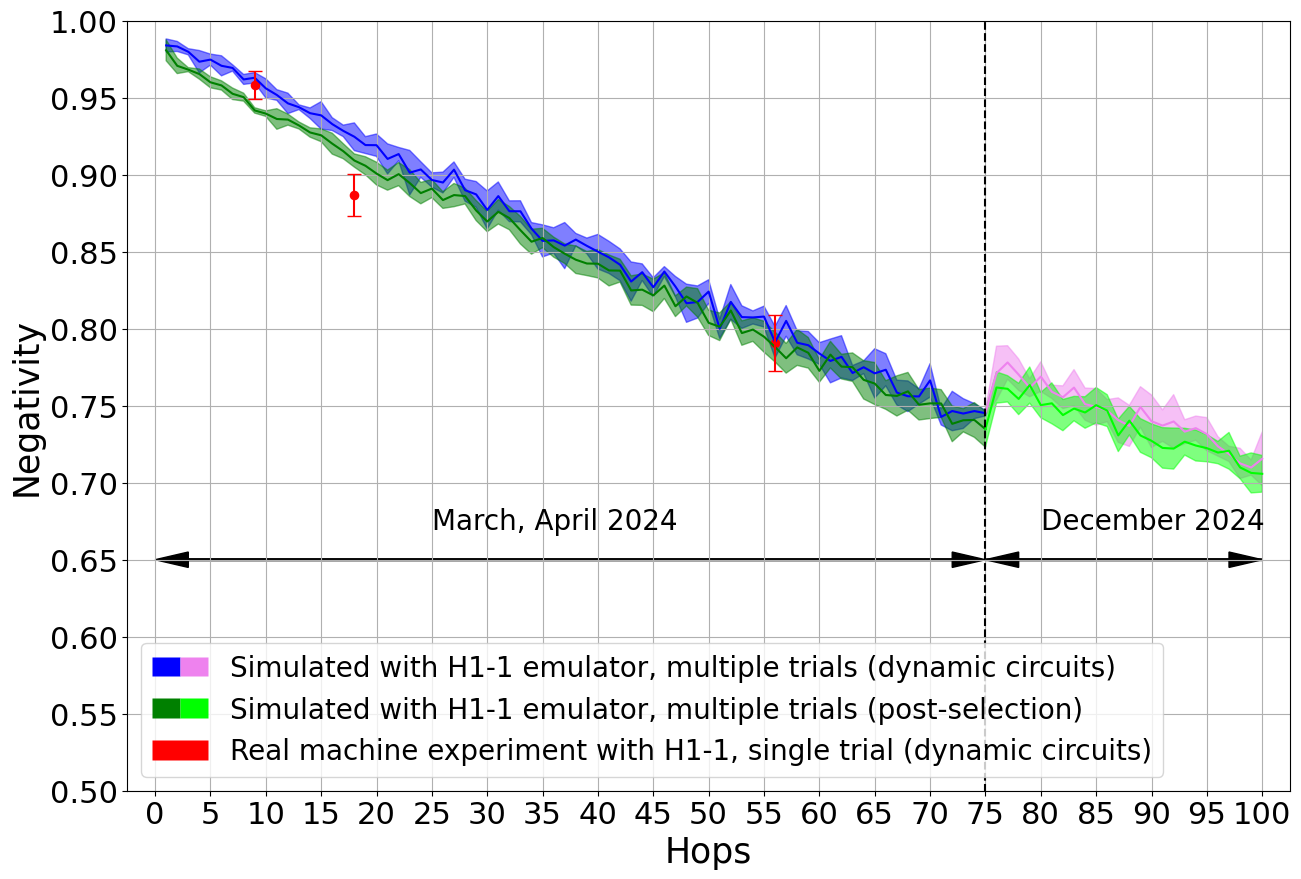

In [71]:
from numpy import pi
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch


figsize = (15, 10)
fig, ax = plt.subplots(figsize = figsize)
handles, labels = ax.get_legend_handles_labels()

gaps_long = list(range(1,101))
ax.plot(gaps_long[:75], quantinuum_simulated_dyn_mit[:75], color='blue')
ax.fill_between(gaps_long[:75], np.array(quantinuum_simulated_dyn_mit[:75])-2*np.array(quantinuum_simulated_dyn_mit_err[:75]),
                np.array(quantinuum_simulated_dyn_mit[:75])+2*np.array(quantinuum_simulated_dyn_mit_err[:75]), 
                label = 'Quantinuum H1-1E Dynamic Circuits (simulated, multiple trials)', color = list(zip(['blue']*19, [0.5]*19)))
ax.plot(gaps_long[:75], quantinuum_simulated_post_mit[:75], color='green')
ax.fill_between(gaps_long[:75], np.array(quantinuum_simulated_post_mit[:75])-2*np.array(quantinuum_simulated_post_mit_err[:75]),
                np.array(quantinuum_simulated_post_mit[:75])+2*np.array(quantinuum_simulated_post_mit_err[:75]), 
                label = 'Quantinuum H1-1E Post-Selection (simulated, multiple trials)', color = list(zip(['green']*19, [0.5]*19)))

ax.plot(gaps_long[74:], quantinuum_simulated_dyn_mit[74:], color='violet')
ax.fill_between(gaps_long[74:], np.array(quantinuum_simulated_dyn_mit[74:])-2*np.array(quantinuum_simulated_dyn_mit_err[74:]),
                np.array(quantinuum_simulated_dyn_mit[74:])+2*np.array(quantinuum_simulated_dyn_mit_err[74:]), 
                label = 'Quantinuum H1-1E Dynamic Circuits (simulated, multiple trials)', color = list(zip(['violet']*19, [0.5]*19)))
ax.plot(gaps_long[74:], quantinuum_simulated_post_mit[74:], color='lime')
ax.fill_between(gaps_long[74:], np.array(quantinuum_simulated_post_mit[74:])-2*np.array(quantinuum_simulated_post_mit_err[74:]),
                np.array(quantinuum_simulated_post_mit[74:])+2*np.array(quantinuum_simulated_post_mit_err[74:]), 
                label = 'Quantinuum H1-1E Post-Selection (simulated, multiple trials)', color = list(zip(['lime']*19, [0.5]*19)))


ax.errorbar([9,18,56], quantinuum_real_dyn_mit, yerr=quantinuum_real_dyn_mit_err, label='Quantinuum H1-1 Dynamic Circuits (real machine, single trial)', color='red',
            capsize=5, ls='')
ax.scatter([9,18,56], quantinuum_real_dyn_mit, color='red', s=35)

ax.vlines(75,0,1,colors='black',linestyles='dashed')
ax.arrow(1, 0.65, 74, 0, head_width=0.01, head_length=3, linewidth=1, color='black', length_includes_head=True)
ax.arrow(74, 0.65, -74, 0, head_width=0.01, head_length=3, linewidth=1, color='black', length_includes_head=True)

ax.arrow(75, 0.65, 25, 0, head_width=0.01, head_length=3, linewidth=1, color='black', length_includes_head=True)
ax.arrow(100, 0.65, -25, 0, head_width=0.01, head_length=3, linewidth=1, color='black', length_includes_head=True)

ax.annotate('March, April 2024',xy=(25,0.67), fontsize=20)
ax.annotate('December 2024',xy=(80,0.67), fontsize=20)
#ax.plot(gaps+[19], ibm_dyn_mean, color = 'darkred')
#ax.fill_between(gaps+[19], ibm_dyn_min, ibm_dyn_max, label='IBM Dynamic Circuits (real machine, multiple trials)',
#                color =  list(zip(['darkred']*19, [0.5]*19)))

#ax.plot(gaps+[19], ibm_post_mean, color='red')
#ax.fill_between(gaps+[19], ibm_post_min, ibm_post_max, label='IBM Post-Selection (real machine, multiple trials)',
#                color =  list(zip(['red']*19, [0.5]*19)))

#ax.plot(gaps_long, quantinuum_ideal_mit, ls='dashed',
#        label = 'Ideal Teleportation', color = 'black', marker = '^')
#ax.plot(gaps, quantinuum_ideal_mit, ls='dashed',
#        label = 'Ideal Post-Selection', color = 'black', marker = '^')
ax.set_xticks(np.arange(0, 101, 5))
ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.set_ylim(bottom=0.5,top=1)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.grid()
ax.margins(0.025, 0.05)

handles.append(MulticolorPatch([('blue'), ('violet')]))
handles.append(MulticolorPatch([('green'), ('lime')]))
handles.append(MulticolorPatch(['red']))
labels.append('Simulated with H1-1 emulator, multiple trials (dynamic circuits)')
labels.append('Simulated with H1-1 emulator, multiple trials (post-selection)')
labels.append('Real machine experiment with H1-1, single trial (dynamic circuits)')
ax.legend(handles, labels, prop={'size': 20}, handler_map={MulticolorPatch: MulticolorPatchHandler()})


#ax.legend(fontsize=13)
ax.set_xlabel("Hops",fontsize=25)
ax.set_ylabel('Negativity',fontsize=25)

fig.savefig('quantinuum results/fidelity (QREM) square plot.pdf',dpi=300, bbox_inches="tight")

75


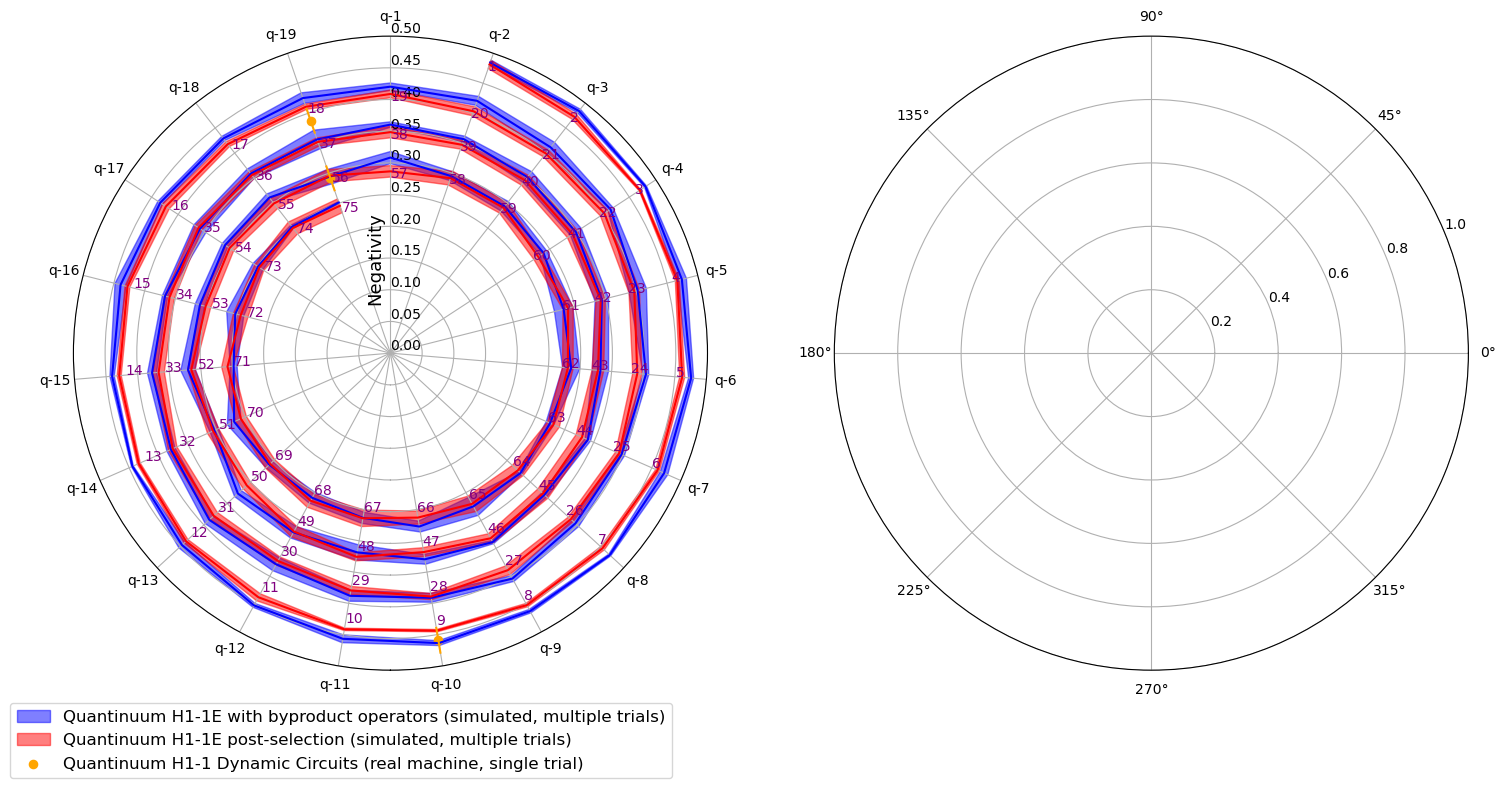

In [16]:
from numpy import pi
theta = np.flip(np.arange(1*2*pi/19,76*2*pi/19,2*pi/19))
print(len(theta))

fig, ax = plt.subplots(1,2, subplot_kw={'projection': 'polar'}, figsize=(18,10))
#ax = plt.subplot(111, polar=True)
ax[0].set_theta_zero_location('N')

ax[0].plot(theta, quantinuum_simulated_dyn_mit, color='blue')
ax[0].fill_between(theta, np.array(quantinuum_simulated_dyn_mit)-2*np.array(quantinuum_simulated_dyn_mit_err),
                np.array(quantinuum_simulated_dyn_mit)+2*np.array(quantinuum_simulated_dyn_mit_err), 
                label = 'Quantinuum H1-1E with byproduct operators (simulated, multiple trials)', color = list(zip(['blue']*19, [0.5]*19)))
ax[0].plot(theta, quantinuum_simulated_post_mit, color='red')
ax[0].fill_between(theta, np.array(quantinuum_simulated_post_mit)-2*np.array(quantinuum_simulated_post_mit_err),
                np.array(quantinuum_simulated_post_mit)+2*np.array(quantinuum_simulated_post_mit_err), 
                label = 'Quantinuum H1-1E post-selection (simulated, multiple trials)', color = list(zip(['red']*19, [0.5]*19)))
ax[0].errorbar([10*2*pi/19,20*2*pi/19,58*2*pi/19], quantinuum_real_dyn_mit, yerr=quantinuum_real_dyn_mit_err, color='orange',
            capsize=0, ls='')
ax[0].scatter([10*2*pi/19,20*2*pi/19,58*2*pi/19], quantinuum_real_dyn_mit, label='Quantinuum H1-1 Dynamic Circuits (real machine, single trial)', color='orange', s=35)

ax[0].set_rmax(0.5)
ax[0].set_rticks(np.arange(0, .55, 0.05)) # Less radial ticks
ax[0].set_xticks([i*2*pi/19-(pi+pi/19) for i in range(1,20)])
ax[0].set_xticklabels(['q-10','q-9','q-8','q-7','q-6','q-5','q-4','q-3','q-2','q-1','q-19','q-18','q-17','q-16','q-15','q-14','q-13','q-12','q-11'])
ax[0].set_ylabel('Negativity', size=13)
ax[0].yaxis.set_label_coords(0.49,0.65)

ax[0].set_rlabel_position(0)  # Move radial labels away from plotted line
label_position=ax[0].get_rlabel_position()
#ax.text(np.radians(label_position+5), ax.get_rmax()/2.2,'Negativity',
#        rotation=90, ha='center',va='center')
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].set_thetalim(-np.pi, np.pi)
ax[0].set_rlim(0,0.5)
for i in range(75):
    angle = theta[i]
    height = quantinuum_simulated_post_mit[i]-0.01
    ax[0].annotate(f'{i+1}',xy=(angle,height), color='purple') 

ax[0].grid(True)
ax[0].legend(loc=(-0.1,-0.17), prop={'size': 12})
#ax.margins(0.025, 0.05)
plt.show()
#fig.savefig('quantinuum results/negativity.pdf',dpi=300, bbox_inches="tight")

100


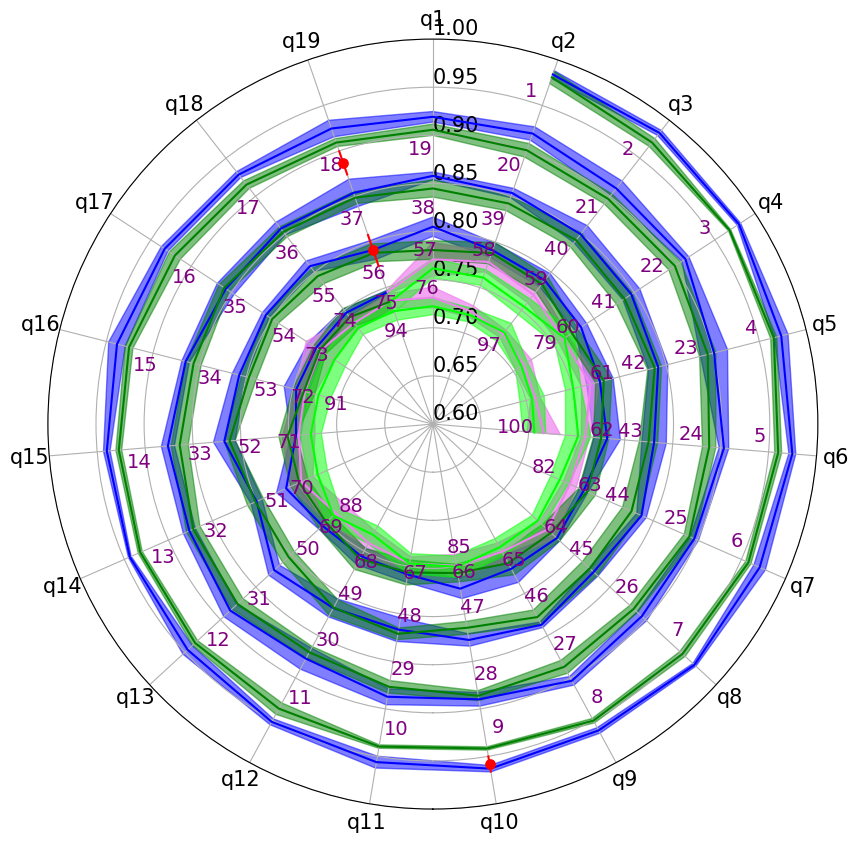

In [11]:
from numpy import pi
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch





#theta = np.flip(np.arange(1*2*pi/19,76*2*pi/19,2*pi/19))
theta = np.flip(np.arange(1*2*pi/19-6*2*pi/19,101*2*pi/19-6*2*pi/19,2*pi/19))
print(len(theta))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
handles, labels = ax.get_legend_handles_labels()
#ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N')

ax.plot(theta[:75], quantinuum_simulated_dyn_mit[:75], color='blue')
ax.fill_between(theta[:75], np.array(quantinuum_simulated_dyn_mit[:75])-2*np.array(quantinuum_simulated_dyn_mit_err[:75]),
                np.array(quantinuum_simulated_dyn_mit[:75])+2*np.array(quantinuum_simulated_dyn_mit_err[:75]), 
                label = 'Simulated with H1-1 emulator, multiple trials (dynamic circuits)', color = list(zip(['blue']*19, [0.5]*19)))
ax.plot(theta[74:], quantinuum_simulated_dyn_mit[74:], color='violet')
ax.fill_between(theta[74:], np.array(quantinuum_simulated_dyn_mit[74:])-2*np.array(quantinuum_simulated_dyn_mit_err[74:]),
                np.array(quantinuum_simulated_dyn_mit[74:])+2*np.array(quantinuum_simulated_dyn_mit_err[74:]), 
                label = 'Simulated with H1-1 emulator, multiple trials (post-selection)', color = list(zip(['violet']*19, [0.7]*19)))


ax.plot(theta[:75], quantinuum_simulated_post_mit[:75], color='green')
ax.fill_between(theta[:75], np.array(quantinuum_simulated_post_mit[:75])-2*np.array(quantinuum_simulated_post_mit_err[:75]),
                np.array(quantinuum_simulated_post_mit[:75])+2*np.array(quantinuum_simulated_post_mit_err[:75]), 
                label = 'Simulated with H1-1 emulator, multiple trials (post-selection)', color = list(zip(['green']*19, [0.5]*19)))
ax.plot(theta[74:], quantinuum_simulated_post_mit[74:], color='lime')
ax.fill_between(theta[74:], np.array(quantinuum_simulated_post_mit[74:])-2*np.array(quantinuum_simulated_post_mit_err[74:]),
                np.array(quantinuum_simulated_post_mit[74:])+2*np.array(quantinuum_simulated_post_mit_err[74:]), 
                label = 'Simulated with H1-1 emulator, multiple trials (post-selection)', color = list(zip(['lime']*19, [0.5]*19)))

ax.errorbar([10*2*pi/19,20*2*pi/19,58*2*pi/19], quantinuum_real_dyn_mit, yerr=np.array(quantinuum_real_dyn_mit_err), color='red',
            capsize=0, ls='',zorder=100)
ax.scatter([10*2*pi/19,20*2*pi/19,58*2*pi/19], quantinuum_real_dyn_mit, label='Real machine experiment with H1-1, single trial (dynamic circuits)', color='red', s=45,
           zorder=100)

ax.set_rmax(1)
ax.set_rticks(np.arange(0, 1.05, 0.05)) # Less radial ticks
ax.set_xticks([i*2*pi/19-(pi+pi/19) for i in range(1,20)])
ax.set_xticklabels(['q10','q9','q8','q7','q6','q5','q4','q3','q2','q1','q19','q18','q17','q16','q15','q14','q13','q12','q11'])
#ax.set_ylabel('Negativity (QREM)', size=13)
ax.yaxis.set_label_coords(0.49,0.65)

ax.set_rlabel_position(0)  # Move radial labels away from plotted line
label_position=ax.get_rlabel_position()
#ax.text(np.radians(label_position+5), ax.get_rmax()/2.2,'Negativity',
#        rotation=90, ha='center',va='center')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_thetalim(-np.pi, np.pi)
ax.set_rlim(0.6,1)
#ax.set_theta_direction(1)
for i in range(56):
    angle = theta[i]+pi/70
    height = quantinuum_simulated_post_mit[i]-0.02
    ax.annotate(f'{i+1}',xy=(angle,height), color='purple', fontsize=14, ha='center', va='center')

for i in range(56,75):
    angle = theta[i]+pi/70
    height = quantinuum_simulated_post_mit[i]
    ax.annotate(f'{i+1}',xy=(angle,height), color='purple', fontsize=14, ha='center', va='center')
    
for i in range(75,100,3):
    angle = theta[i]+pi/70
    height = quantinuum_simulated_post_mit[i]-0.02
    ax.annotate(f'{i+1}',xy=(angle,height), color='purple', fontsize=14, ha='center', va='center')
    
ax.grid(True)

handles.append(MulticolorPatch([('blue',0.5), ('violet',0.7)]))
handles.append(MulticolorPatch([('green',0.5), ('lime',0.5)]))
handles.append(MulticolorPatch(['red']))
labels.append('Simulated with H1-1 emulator, multiple trials (dynamic circuits)')
labels.append('Simulated with H1-1 emulator, multiple trials (post-selection)')
labels.append('Real machine experiment with H1-1, single trial (dynamic circuits)')
#ax.legend(handles, labels, loc=(0,-0.2), prop={'size': 16}, handler_map={MulticolorPatch: MulticolorPatchHandler()})
ax.margins(0.025, 0.05)
plt.show()
fig.savefig('quantinuum results/fidelity (QREM).pdf',dpi=300, bbox_inches="tight")